# SWMT variability in easterly simulations, calculations to save diagnostics

In [6]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma0,sigma1

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

#figdir = '/g/data/v45/akm157/figures/Weddell_connectivity/SWMT/'

In [7]:
session = cc.database.create_session()
experiment_ryf = '01deg_jra55v13_ryf9091'

In [8]:
start_time='2150-01-01'
end_time='2159-12-31'
time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

# stitch together west and east sections:
outpath = '/g/data/v45/akm157/model_data/access-om2/'+experiment_ryf+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_control_west = output.net_transformation_control
outpath = '/g/data/v45/akm157/model_data/access-om2/'+experiment_ryf+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_control_east = output.net_transformation_control
net_transformation_control = xr.concat([net_transformation_control_west,net_transformation_control_east],dim='xt_ocean').mean('year')

In [13]:
# topography data:
ht = cc.querying.getvar(experiment_ryf,'ht' , session,n=1)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90
fontsize=16

# set up empty masks:
Ross_mask = net_transformation_control[0,...]*0+1
Ross_mask = Ross_mask.fillna(1)

Adelie_mask = Ross_mask.copy()
Weddell_mask = Ross_mask.copy()
Prydz_mask = Ross_mask.copy()
yt_ocean = Ross_mask.yt_ocean
xt_ocean = Ross_mask.xt_ocean

# set regions:
Ross_mask = Ross_mask.where(yt_ocean<-72).where(yt_ocean>-79).where(xt_ocean>161.5-360).where(xt_ocean<170-360)
Prydz_mask = Prydz_mask.where(yt_ocean<-67).where(yt_ocean>-69).where(xt_ocean>58).where(xt_ocean<73)
Adelie_mask = Adelie_mask.where(yt_ocean<-66.2).where(yt_ocean>-69).where(xt_ocean>138-360).where(xt_ocean<148-360)

# two area to include for this one:
Weddell_maskW = Weddell_mask.where(yt_ocean<-70).where(yt_ocean>-79).where(xt_ocean>297-360).where(xt_ocean<305-360)
Weddell_maskE = Weddell_mask.where(yt_ocean<-75).where(yt_ocean>-79).where(xt_ocean>305-360).where(xt_ocean<320-360)
Weddell_mask = Weddell_maskE.fillna(0) + Weddell_maskW.fillna(0)
Weddell_mask = Weddell_mask.where(Weddell_mask == 1)

# combine all masks:
combined_mask = Adelie_mask.fillna(0) + Ross_mask.fillna(0)*2 + Weddell_mask.fillna(0)*3 + Prydz_mask.fillna(0)*4

combined_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],linewidths=0.5,colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

array([27.83, 28.03, 27.81, 27.79])

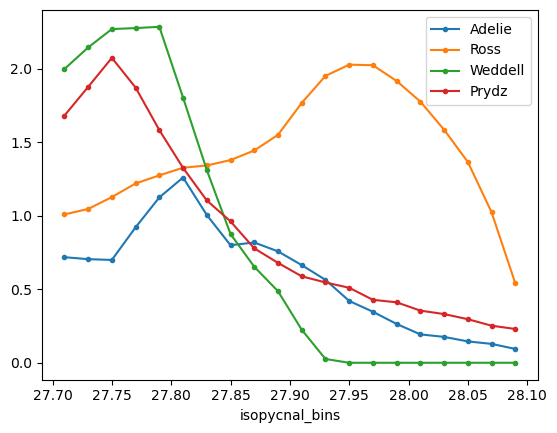

In [16]:
## Find density thresholds to use for each region using a 10 year average of the control:

time_slice = slice(2150,2159)
control_transformation_mean = net_transformation_control

area_t = cc.querying.getvar(experiment_ryf, 'area_t', session, n=1)

regions = ['Adelie','Ross','Weddell','Prydz']
density_threshold = np.zeros(4)

# use density where SWMT is 70% of peak value:
percent_max_SWMT = 0.7

for DSW_region_count in range(4):
    region = regions[DSW_region_count]
    area_mask = area_t.where(combined_mask == DSW_region_count + 1)
    swmt_sum_region = (control_transformation_mean*area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_sum_region.plot(marker='.',label=region)
    # find max value:
    swmt_max = swmt_sum_region.max().values
    # find density where swmt = 0.7*swmt_max:
    density_threshold[DSW_region_count] = swmt_sum_region.where(swmt_sum_region >= swmt_max*percent_max_SWMT,drop=True)[-1].isopycnal_bins.values
    
plt.legend()
    
# TO DO: update SWMT calculation to narrow in on these densities with finer density bins:
density_threshold

In [23]:
density_threshold

array([27.83, 28.03, 27.81, 27.79])

In [45]:
regions

['Adelie', 'Ross', 'Weddell', 'Prydz']

(-78.51091138395503, -72.0)

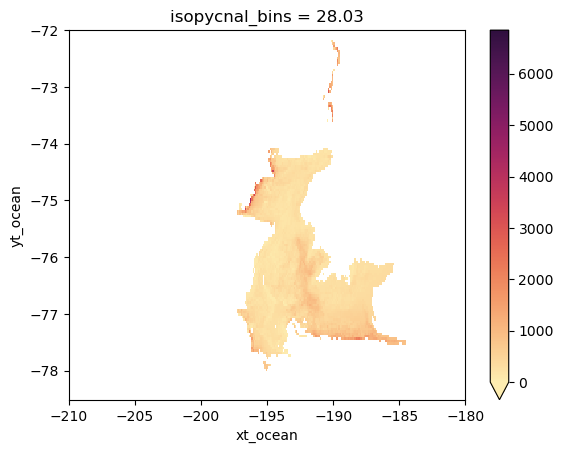

In [70]:
(net_transformation_control* area_t).sel(isopycnal_bins = density_threshold[1], method = 'nearest').squeeze().plot(vmin = 0, cmap = cmocean.matter)
plt.xlim(-210,-180)
plt.ylim(None, -72)